# **[5] Volume Rendering**
**볼륨 렌더링** 이란 광선(ray)을 따라 분포하는 샘플 포인트의 색(color)과 밀도(density)를 이용해, 그 광선에 대응하는 픽셀의 최종 색깔을 계산하는 과정입니다.  
NeRF에서 제시한 볼륨 렌더링의 수식은 아래와 같습니다.  

$$
\hat{C}({r}) \;=\; \sum_{i=1}^N \; T_i \,\bigl(1 - \exp(-\sigma_i \,\delta_i)\bigr)\;\mathbf{c}_i  
\quad \text{where}\quad
T_i \;=\; \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr).
$$

여기서:

1. $\mathbf{r}$: 광선(ray).  
2. $i=1\ldots N$: 광선을 따라 샘플링한 점들의 인덱스.  
3. $\sigma_i$: i번째 점의 **밀도(density)**. (NeRF 네트워크 출력값의 마지막 차원 `output[:, 3]`)
4. $\mathbf{c}_i$: i번째 점의 **색(color)**. (NeRF 네트워크 출력값의 1, 2, 3 차원 `output[:, :2]`)
5. $\delta_i$: i번째 샘플과 이전 샘플 사이의 거리. (두께로 생각할 수 있음)  
6. $T_i$: i번째 샘플까지 도달하기 전까지의 “누적 투명도”.  



## 1. $\alpha_i = \bigl(1 - \exp(-\sigma_i \delta_i)\bigr)$

- 광선이 두께가 $\delta_i$, 밀도가 $\sigma_i$인 지점 i를 지나면서 불투명이 발생한다.
- 즉, $\alpha_i$는 **i번째 샘플 구간**(밀도 $\sigma_i$, 두께 $\delta_i$)에서 불투명도를 의미하며, 이 값이 클수록 해당 지점의 색깔 $c_i$이 선명하게 보입니다.
- 이 값은 0~1 사이이며, 구간이 짧거나($\delta_i$ 작음) 밀도가 낮으면($\sigma_i$ 작음) → $\alpha_i\approx 0$.

$$
\alpha_i = 1 - e^{-\sigma_i \,\delta_i}.
$$

- 여기에 $\sigma_i \delta_i$를 하나의 변수 $x$라고 놓으면,  
  $$
    \alpha_i = 1 - e^{-x}.
  $$

### 그래프 $y = 1 - e^{-x}$ 특징
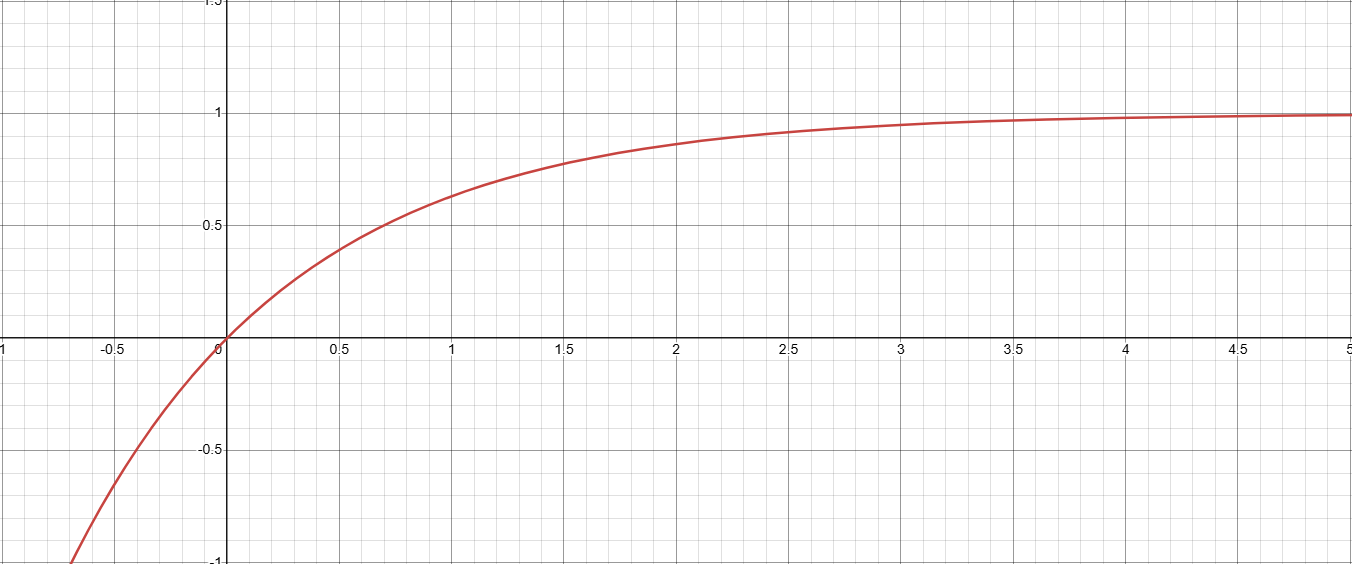
1. $x=0$일 때 $y=0$. (즉, 구간 길이와 밀도가 0이면 흡수도 0)
2. $x \to \infty$일 때 $e^{-x}\to 0$, 따라서 $y\to 1$. (밀도$\times$두께가 매우 크면 구간을 완전히 불투명하게 가림)
3. 단조 증가: $x$가 커질수록 $y$가 0→1 사이를 늘려가며 증가.  

이를 통해  
- 작은 구간($\delta_i$ 작거나 $\sigma_i$ 작을 때) → “거의 투과 ($\alpha\approx 0$)”하여 $c_i$의 값이 적게 표현  
- 구간이 클수록(또는 밀도가 크면) → “매우 불투명 ($\alpha\approx 1$)”해지고 $c_i$의 값이 많이 표현  
이라는 물리적 직관을 얻을 수 있습니다.


## 2. $T_i = \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr)$

- i번째 지점 전까지, 광선이 지나온 모든 구간 $j=1\ldots i-1$에서의 밀도 $\sigma_j$와 두께 $\delta_j$를 합산한 것.
- 즉, **이전까지 빛이 흡수된 비율의 총합**
- 만약 앞 구간들의 밀도 합이 크면, $T_i$가 작아져서 현재 샘플의 값이 거의 반영되지 않습니다.
$$
T_i = \exp\bigl(-\underbrace{\sum_{j=1}^{i-1} \sigma_j\,\delta_j}_{x}\bigr).
$$

- 여기서 $\sum_{j=1}^{i-1} \sigma_j\,\delta_j$를 하나의 변수 $x$라 두면,

$$
T_i = e^{-x}.
$$

### 그래프 $y = e^{-x}$ 특징
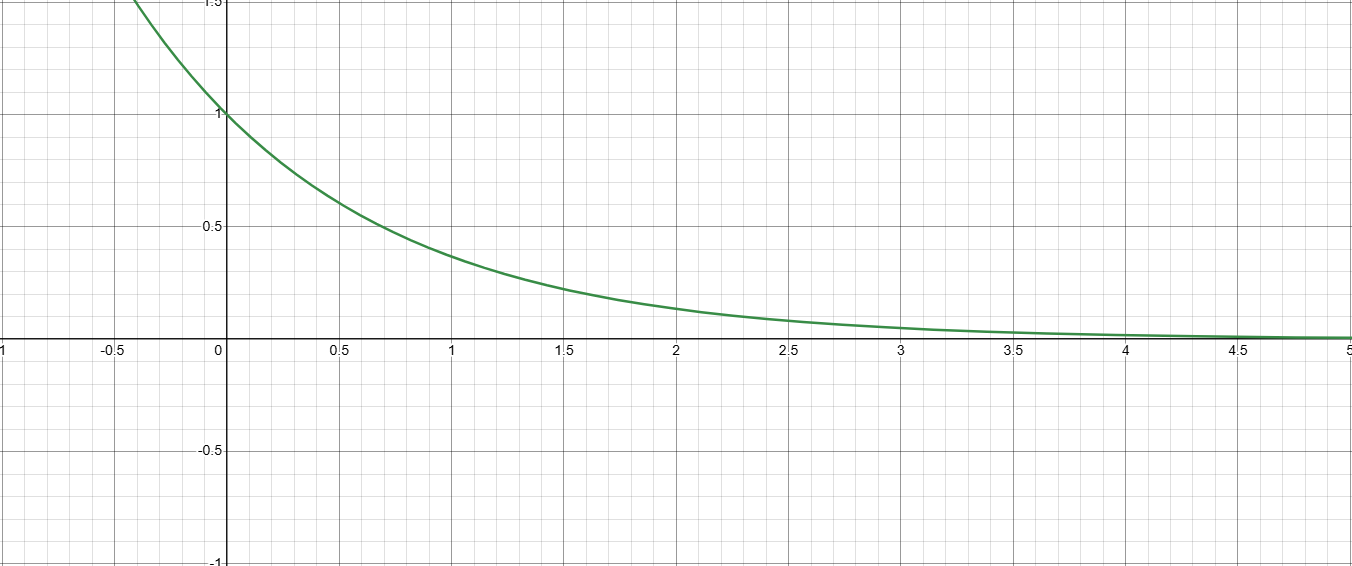
1. $x=0$ → $y=1$. (지금까지 빛의 흡수가 전혀 없었다면, 가중치가 1)  
2. $x\to \infty$ → $y\to 0$. (앞에서 이미 많은 흡수가 일어났다면, 현재 시점의 가중치가 0에 가까움)  
3. **단조 감소**: $x$가 커질수록 $e^{-x}$는 1→0 범위로 줄어든다.

위 그래프의 특징을 바탕으로 $T_i$를 이해해보면,  
- 앞쪽에 빛을 가리는 물체가 없으면 → $T_i \approx 1$ 
- 앞에서 빛을 가리는 물체가 있으면 → $T_i \approx 0$

## 3. 식 전체: $\hat{C}(\mathbf{r}) = \sum_{i=1}^N T_i \,\alpha_i \,\mathbf{c}_i$

- **i번째 샘플의 기여도** = “이 지점까지 도달한 빛의 비율($T_i$) × 이 지점의 불투명도($\alpha_i$)” × “색($\mathbf{c}_i$)”.
- 모든 샘플을 합산하면 최종 픽셀 색($\hat{C}$).
- **NeRF**는 MLP로부터 학습 가능한 파라미터인 $\sigma_i,\mathbf{c}_i$를 추론해 이 식을 계산함으로써, 특정 위치를 바라보는 카메라의 각 픽셀 색상을 결정할 수 있게 됩니다.

## 4. $T_i$ 수식의 변형식 유도
NeRF 논문에서

$$
T_i = \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr)
$$

라는 식이 먼저 등장하지만, 코드 구현은 아래의 식으로 합니다.

$$
T_i = \prod_{j=1}^{i-1} (1-\alpha_j)
$$


이 두 수식은 동치이며, $\alpha_j$의 정의를 대입해봄으로써 증명 가능합니다.


### 1) $\alpha_j = 1 - \exp(-\sigma_j \delta_j)$


$$
\alpha_j
= 1 - \exp(-\sigma_j \,\delta_j)
\quad\Longrightarrow\quad
1 - \alpha_j
= \exp(-\sigma_j \,\delta_j).
$$

즉, $(1-\alpha_j)$는 “그 샘플 구간에서 흡수되지 않고 투과되는 비율” $\exp(-\sigma_j \delta_j)$와 같습니다.


### 2) 두 식이 같다는 증명

#### (a) 논문 공식:

$$
T_i 
= \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr).
$$

#### (b) 코드 공식:

$$
T_i
= \prod_{j=1}^{i-1}(1-\alpha_j).
$$

#### (c) 증명:

$1-\alpha_j = \exp(-\sigma_j\delta_j)$이므로,

$$
\prod_{j=1}^{i-1}(1-\alpha_j)
= \prod_{j=1}^{i-1}\exp(-\sigma_j\delta_j)
$$

이때, 아래와 같이 **지수함수의 곱**이 **지수들의 합**로 합쳐지는 **기본 성질**을 이용하면

$$
\prod_{j=1}^{n} \exp(x_j)
= \exp(x_1)\,\exp(x_2)\,\cdots \exp(x_n)
= \exp\bigl(x_1 + x_2 + \cdots + x_n\bigr).
$$
따라서 해당 수식은 아래와 같이 유도 됩니다.
$$
\prod_{j=1}^{i-1}\exp(-\sigma_j\delta_j)
= \exp\Bigl(\sum_{j=1}^{i-1}(-\sigma_j\delta_j)\Bigr)
= \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr).
$$

$$
\therefore
T_i=\prod_{j=1}^{i-1}(1-\alpha_j)
= \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr),
$$


### 3) 두 번째 수식으로 구현한 이유

코드를 살펴보면, 
- 우선 MLP 출력값 $\sigma$로부터 $\alpha_j = 1-\exp(-\sigma_j\delta_j)$을 먼저 구하고,  
- 이를 바탕으로 간단히 “$(1-\alpha_j)$”를 누적곱(cumprod) 하여 Transmittance $T_i$를 계산합니다.  

이 방식이 **구현**에 편리하기 때문에, 코드상에서는 이 공식을 사용한 것입니다.  
지금부터는 실제 함수의 코드를 한 줄씩 짚어가며 수식들이 어떻게 구현 되었는지 살펴보겠습니다.

## 5. 코드 구현
### raw2outputs()
**NeRF 네트워크의 output** 인 **모든 샘플 포인트의 RGB값과 덴시티 값** 을 받아 **볼륨 렌더링**을 통해 **각 픽셀** 에 대한 **최종 RGB값 및 투명도 맵** 등을 계산하는 함수.
- input data: 배치 단위의 광선에서 생성된 모든 샘플 포인트에 대한 RGB값과 덴시티 값  
- ouput data: 배치 단위의 RGB 맵 등

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

def raw2outputs(
    raw,            # shape: (N_rays, N_samples, 4)  -> 모델의 output [R, G, B, density] 
    z_vals,         # shape: (N_rays, N_samples)     -> 샘플 포인트들까지의 깊이 (near bound부터 far bound까지를 N_samples로 내분한 뒤, N_rays만큼 expand한 것)
    rays_d,         # shape: (N_rays, 3)             -> get_rays(H, W, K, c2w)를 통해 계산한 rays_o, rays_d
    raw_noise_std=0,# density에 추가할 노이즈 크기
    white_bkgd=False,
):
    """
    NeRF의 볼륨 렌더링 공식에 따라, (R,G,B,density) -> 각 광선당 하나의 최종 RGB, depth, disparity, acc, weights 계산.
    
    returns:
        rgb_map   : (N_rays, 3)         각 광선별 최종 RGB
        disp_map  : (N_rays,)           광선별 disparity (1/depth)
        acc_map   : (N_rays,)           광선별 alpha 누적합(투명도 맵)
        weights   : (N_rays, N_samples) 각 샘플별 가중치 누적합(광선상의 장애물 여부)
        depth_map : (N_rays,)           광선별 추정 깊이
    """

    # ---------------------------------------------
    # 1) 밀도(density) -> alpha 로 바꾸는 람다함수 선언
    #    raw2alpha( density_value , 샘플간 거리, 활성함수=ReLU )
    #    α=1−exp(−σδ): alpha = 1 - exp( - relu(density) * distance )
    # ---------------------------------------------
    raw2alpha = lambda raw_val, dists, act_fn=F.relu: 1.0 - torch.exp(-act_fn(raw_val) * dists)
    # raw_val: densty 값 raw[..., 3] (N_rays, N_samples)
    # act_fn(raw_val): density는 음수를 가질 수 없으므로 ReLU를 취해 음의 값을 0으로 초기화.
    # dists: 각 샘플 포인트간 거리. (N_rays, N_samples).

    # ---------------------------------------------
    # 2) 각 샘플 구간 사이의 거리 계산
    #    z_vals[...,1:] -> 1~N까지 샘플 Z 좌표 (이 때 좌표는 near과 far 사이를 선형 분할한 후, 노이즈를 섞은 것. 하단의 render_rays() 참조)
    #    z_vals[...,:-1] -> 0~N-1까지 샘플 Z 좌표
    #    z_vals[...,1:] - z_vals[...,:-1] -> (N_rays, N_samples-1)
    #    맨 끝 샘플은 무한대를 상정하여, 1e10이라는 큰 값을 추가 -> (N_rays, N_samples)
    # ---------------------------------------------
    dists = z_vals[..., 1:] - z_vals[..., :-1]              # shape: (N_rays, N_samples-1)
    dists = torch.cat(
        [dists, 1e10 * torch.ones_like(dists[..., :1])],
        dim=-1
    )                                                       # shape: (N_rays, N_samples)

    # ---------------------------------------------
    # 3) 방향 벡터의 길이를 곱해, 실제 물리적 거리로 보정
    #    rays_d: (N_rays, 3) -> rays_d[...,None,:] -> (N_rays,1,3) (하나의 레이에 존재하는 모든 N_samples는 동일한 방향으로 나아가므로 차원을 늘려준 뒤, 아래의 브로드캐스팅 연산으로 같은 값을 채운다.)
    #    norm(..., dim=-1) -> (N_rays,1) 즉, 벡터의 크기를 나타내는 하나의 스칼라 값을 계산
    #    dists * torch.norm(...) -> 브로드캐스팅 곱 -> (N_rays, N_samples)
    #    dists는 near, far bound를 N_samples로 나눈 것들 사이의 거리 차이에 불과하므로, 실제 rays_d의 크기를 곱해주는 것.
    #    예를 들어 near = 2, far = 6 이라면, rays_d를 곱해 rays_d의 2배부터 6배 거리까지 N_rands개 만큼 분포하는 샘플들 간의 거리를 저장.
    # ---------------------------------------------
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # ---------------------------------------------
    # 4) raw[..., :3] => 맨 마지막 차원은 rgb 값을 지니는 3 인덱스 전까지만 슬라이스 (N_rays, N_samples, 3)
    #    rgb 값은 0부터 255까지의 양의 제한을 가지므로 sigmoid를 태워 [0..1] 범위로 축소
    # ---------------------------------------------
    rgb = torch.sigmoid(raw[..., :3])   # shape: (N_rays, N_samples, 3)

    # ---------------------------------------------
    # 5) density(d) + noise 값을 위의 raw2alpha 함수를 이용해 모든 샘플에 대한 alpha 계산
    #    raw[...,3] => 이전까지의 차원은 모두 포함하고, density 값을 지니는 맨 마지막 3차원만 슬라이스 (N_rays, N_samples)
    #    noise: same shape, 정규분포 난수 * raw_noise_std
    # ---------------------------------------------
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[..., 3].shape) * raw_noise_std  # (N_rays,N_samples)
    
    alpha = raw2alpha(raw[..., 3] + noise, dists)  # shape: (N_rays,N_samples)

    # ---------------------------------------------
    # 6) weights = α_i * T_i
    #    T_i = ∏(1-α_j) for j < i
    # ---------------------------------------------
    alphas_shifted = torch.cat([
        torch.ones((alpha.shape[0], 1)),  # (N_rays, 1) 첫 시작점은 빛의 흡수가 없으므로 α_0 = 0 -> (1-α+0) = 1을 맨 처음 원소로 삽입
        1. - alpha + 1e-10                # (N_rays, N_samples)
    ], dim=-1)                            # (N_rays, N_samples+1)

    # cumprod -> 누적곱 -> 마지막에 [:, :-1]로 차원 맞춤
    trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1]  # (N_rays, N_samples)
    # alphas_shifted (N_rays, N_samples+1)를 맨 뒤 차원(-1)에 대해 누적곱 하면, N_samples+1들이 모두 누적되어 (N_rays, )가 되는 것이 아니라, 순차적으로 누적곱 한 값들이 두 번째 차원에 업데이트 된다.
    # 따라서 torch.cumprod(alphas_shifted, dim=-1) (N_rays, N_samples+1)
    # [:, :-1]를 통해 맨 마지막 값은 절삭 (N_rays, N_samples)
    
    # weights = α_i * T_i
    weights = alpha * trans  # 텐서의 요소별 곱셈은 맨 마지막 차원에 대해 이루어지므로 shape (N_rays, N_samples)

    # ---------------------------------------------
    # 7) 최종 RGB: (N_rays,3)
    #    weights[...,None]: (N_rays,N_samples,1)
    #    rgb:               (N_rays,N_samples,3)
    #    브로드캐스팅 곱 => (N_rays,N_samples,3)ㅁ
    #    sum(-2) => 두번째 차원으로 모두 더해서 (N_rays,3)
    #    수식의 C_hat(r) = Σ(T*c)를 구현
    # ---------------------------------------------
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # (N_rays,3)

    # ---------------------------------------------
    # 8) 깊이(Depth)
    #    z_vals: (N_rays,N_samples)
    #    weights: same shape
    #    => sum(weights * z_vals, -1) -> (N_rays,)
    # ---------------------------------------------
    depth_map = torch.sum(weights * z_vals, dim=-1)         # (N_rays,)

    # ---------------------------------------------
    # 9) Disparity(1/Depth) -> (N_rays,)
    #    sum(weights,-1)가 0일 수도 있으니 안정화 처리를 위해 max(1e-10, ...)
    # ---------------------------------------------
    disp_map = 1./torch.max(
        1e-10 * torch.ones_like(depth_map),
        depth_map / torch.sum(weights, dim=-1)
    )

    # ---------------------------------------------
    # 10) alpha 누적합 => (N_rays,)
    #     => 이 값이 크면 해당 광선 상에 장애물이 있는 것이고, 작다면 장애물이 없는 것이다.
    # ---------------------------------------------
    acc_map = torch.sum(weights, dim=-1)   # (N_rays,)

    return rgb_map, disp_map, acc_map, weights, depth_map

#### (a) alpha, alpha_shifted 변수에 대한 부가 설명
```python
alpha = raw2alpha(raw[..., 3] + noise, dists)  # shape: (N_rays,N_samples)

alphas_shifted = torch.cat([
    torch.ones((alpha.shape[0], 1)),
    1.-alpha + 1e-10
], dim=-1) # shape: (N_rays,N_samples + 1)
```
- “$\alpha_i = 1-\exp(-\sigma_i\delta_i)$”.
- **`alpha`**: “$\alpha_i = 1-\exp(-\sigma_i\delta_i)$”의 계산 결과. shape `(N_rays, N_samples)`.
- **`alpha_shifted`**: `alpha`의 두 번째 차원 맨 앞에 1의 값을 가지는 원소를 추가.
이는 $T_i$를 계산하기 위한 트릭. shape `(N_rays, N_samples + 1)`.

먼저 `alphas_shifted`의 인덱스를 살펴보면:

- alphas_shifted[i,0] = 1.0 
- alphas_shifted[i,1] = (1 - alpha[i,0])
- alphas_shifted[i,2] = (1 - alpha[i,1])
- …
- alphas_shifted[i,j] = (1 - alpha[i,j-1])

즉, [i,j] 인덱스는 바로 전 샘플인 [i,j-1]의 계산 결과를 가지고 있습니다.  
따라서 이를 N_samples 차원으로 누적곱 하면,
- 첫 번째 항 = 1.0
- 두 번째 항 = (1 - alpha[i,0])
- 세 번째 항= (1 - alpha[i,0]) * (1 - alpha[i,1])
…  
- $i$ 번째 항= $\prod_{k=1}^{i-1}(1-\alpha_k) = T_i$라고 표현할 수 있습니다. 
- 마지막 원소만 삭제하여 N개의 값만 남기면, 모든 $T_i$를 구할 수 있습니다.

따라서 **`alpha_shifted`** 에 1을 삽입한 이유는 다음과 같습니다
- 광선의 시작 지점에는 빛의 흡수가 없기 때문에 $(1-\alpha)$의 값이 1이다.
- 항을 하나씩 뒤로 미뤄 $T_i$를 구할 수 있다.

#### (b) trans, weights 변수에 대한 부가 설명
실제로 코드를 보시면 transmittance $T_i$는 아래와 같이 alpha_shifted를 이용해 구합니다.
```python
trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1] # shape: (N_rays,N_samples)

# weights = α_i * T_i
weights = alpha * trans  # shape (N_rays, N_samples)
```
- `torch.cumprod(alphas_shifted, dim=-1)`: 누적 곱을 마지막 축(N_samples)으로 계산. `(N_rays, N_samples+1)`.  
- 슬라이싱 `[:, :-1]`을 통해 맨 마지막 원소 절삭. `(N_rays, N_samples)`.
- 이후 `trans`와 `alpha`를 곱해 `weights` 계산

In [3]:
def raw2outputs_debug(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False):
    """
    raw: [N_rays, N_samples, 4] -> (R,G,B, density)
    z_vals: [N_rays, N_samples]
    rays_d: [N_rays, 3]
    raw_noise_std: standard deviation for noise added to density
    ...
    """
    # 1) 작은 helper: density -> alpha
    raw2alpha = lambda r, d, act_fn=F.relu: 1.0 - torch.exp(-act_fn(r) * d)
    
    # 2) 거리차: (N_rays, N_samples-1)
    dists = z_vals[...,1:] - z_vals[...,:-1]
    # 마지막 샘플은 "무한"에 해당
    dists = torch.cat([dists, 1e10 * torch.ones_like(dists[...,:1])], dim=-1)
    # 광선 길이 보정
    dists = dists * torch.norm(rays_d[...,None,:], dim=-1)

    # 3) RGB: (N_rays, N_samples, 3)
    rgb = torch.sigmoid(raw[..., :3])

    # 4) density+noise -> alpha
    noise = 0.0
    if raw_noise_std > 0.0:
        # shape = (N_rays, N_samples)
        noise = torch.randn(raw[...,3].shape) * raw_noise_std
    alpha = raw2alpha(raw[...,3] + noise, dists)

    # 5) weights = alpha * (누적 곱)(1 - alpha)
    #    T_i = ∏(1 - alpha_j), j < i
    #    shape: (N_rays, N_samples)
    alphas_shifted = torch.cat([
        torch.ones((alpha.shape[0],1)), 
        1.-alpha + 1e-10
    ], dim=-1)   # (N_rays, N_samples+1)
    
    trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1]
    weights = alpha * trans # (N_rays,N_samples)

    # 6) ray별 RGB
    #    weights: (N_rays,N_samples), shape -> (N_rays,N_samples,1)
    #    rgb: (N_rays,N_samples,3)
    rgb_map = torch.sum(weights[...,None] * rgb, dim=-2)

    # 7) depth
    depth_map = torch.sum(weights * z_vals, dim=-1)
    # 8) disparity: 1/Depth
    disp_map = 1./torch.max(
        1e-10 * torch.ones_like(depth_map),
        depth_map / torch.sum(weights, dim=-1)
    )
    # 9) alpha 합
    acc_map = torch.sum(weights, dim=-1)

    return rgb_map, depth_map, disp_map, acc_map, weights

if __name__ == "__main__":
    # --------------------------
    # 예시 입력 만들기
    # --------------------------
    N_rays = 2      # 광선 2개
    N_samples = 3   # 샘플 3개
    raw_noise_std = 0.1   # density 노이즈 표준편차

    # (A) raw: shape (N_rays,N_samples,4)
    #    여기서는 [ R, G, B, density ]로 가정
    raw = torch.tensor([
        # ray 0
        [[ 0.5,  1.2,  -0.3,   0.2 ],
        [ 2.0, -1.0,   0.1,   1.0 ],
        [ 0.8,  0.0,   2.5,   0.5 ]],

        # ray 1
        [[-0.2,  0.3,   1.7,   0.4 ],
        [ 0.9,  0.9,   0.9,   0.2 ],
        [ 1.5, -0.5,   0.7,   1.1 ]]
    ], dtype=torch.float32)

    # (B) z_vals: shape (N_rays, N_samples)
    #    샘플 지점의 깊이(혹은 t 값)
    z_vals = torch.tensor([
        [1.0, 2.0, 3.0],
        [2.5, 3.0, 4.0]
    ], dtype=torch.float32)

    # (C) rays_d: shape (N_rays, 3)
    #    광선 방향 (정규화 안되어있어도 됨)
    rays_d = torch.tensor([
        [1.0,  0.0,  0.0],   # x축 방향
        [0.2,  0.9, -0.3]    # 임의 벡터
    ], dtype=torch.float32)

    # --------------------------
    # 함수 호출
    # --------------------------
    rgb_map, depth_map, disp_map, acc_map, weights = raw2outputs_debug(
        raw, z_vals, rays_d, raw_noise_std=raw_noise_std
    )

    # --------------------------
    # 결과 출력
    # --------------------------
    print("raw (input):", raw.shape)
    print(raw, "\n")

    print("z_vals (input):", z_vals.shape)
    print(z_vals, "\n")

    print("rays_d (input):", rays_d.shape)
    print(rays_d, "\n")

    print(">>> Output <<<")
    print("rgb_map =", rgb_map.shape, "\n", rgb_map, "\n")
    print("depth_map =", depth_map.shape, "\n", depth_map, "\n")
    print("disp_map =", disp_map.shape, "\n", disp_map, "\n")
    print("acc_map =", acc_map.shape, "\n", acc_map, "\n")
    print("weights =", weights.shape, "\n", weights, "\n")

raw (input): torch.Size([2, 3, 4])
tensor([[[ 0.5000,  1.2000, -0.3000,  0.2000],
         [ 2.0000, -1.0000,  0.1000,  1.0000],
         [ 0.8000,  0.0000,  2.5000,  0.5000]],

        [[-0.2000,  0.3000,  1.7000,  0.4000],
         [ 0.9000,  0.9000,  0.9000,  0.2000],
         [ 1.5000, -0.5000,  0.7000,  1.1000]]]) 

z_vals (input): torch.Size([2, 3])
tensor([[1.0000, 2.0000, 3.0000],
        [2.5000, 3.0000, 4.0000]]) 

rays_d (input): torch.Size([2, 3])
tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.2000,  0.9000, -0.3000]]) 

>>> Output <<<
rgb_map = torch.Size([2, 3]) 
 tensor([[0.7857, 0.4064, 0.6474],
        [0.7496, 0.4644, 0.6994]]) 

depth_map = torch.Size([2]) 
 tensor([2.2171, 3.6194]) 

disp_map = torch.Size([2]) 
 tensor([0.4510, 0.2763]) 

acc_map = torch.Size([2]) 
 tensor([1., 1.]) 

weights = torch.Size([2, 3]) 
 tensor([[0.1194, 0.5440, 0.3366],
        [0.1319, 0.1828, 0.6854]]) 



### sample_pdf()
Fine 네트워크에 들어갈 샘플 포인트를 추가적으로 추출하는 함수

In [ ]:
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    """
    Importance Sampling으로 새로운 샘플의 z좌표(또는 깊이)를 뽑아내는 함수.

    [배경]
    --------------------------------------------------------------------------------------
    - NeRF에서 코스(coarse) 레이어의 샘플 지점들로부터 "weights"(= a_i * T_i)를 구하고,
      이를 확률분포 함수(pdf)로 삼아 더 많은 샘플을 "중요도 있게" 추가(fine 모델)하려고 함.
    - 이 함수는 'Inverse Transform Sampling' 기법을 사용:
      1) weights -> pdf -> cdf
      2) uniform random (u) -> cdf^-1(u)
      3) -> 새 z샘플(점) 추출

    [입력 설명]
    --------------------------------------------------------------------------------------
    - bins : shape (N_rays, Coarse Model's N_samples - 1) = (N_rays, M) 
        코스(coarse) 모델에 입력된 샘플 포인트들(z_vals)의 중간 지점들인 z_vals_mid
        * 실제론 'z_vals의 중간점'이지만, 구현 편의상 "bins"라 부름.
          코스 모델의 N_samples 사이의 중간값들이므로 N_samples - 1개 존재 (이하 N_samples - 1 = M으로 칭함)

    - weights: raw2outputs 함수에서 계산한 샘플별 가중치 (a_i * T_i) (N_rays, corase 모델의 N_samples)
               이 때, smaple_pdf 함수에 넘겨지는 인자는 맨앞, 맨뒤 시작점을 절삭해
               weighs[..., 1: -1]로 (N_rays, corase 모델의 N_samples - 2) = (N_rays, M - 1)

    - N_samples: fine 모델에서 새로 추출할 샘플 개수 (Coarse Model의 N_samples와 다름에 유의!)

    - det : bool
        True면 '균등분할'에 따라 deterministic하게 샘플 (테스트 등),
        False면 실제로 랜덤하게 뽑음.

    - pytest : bool
        True면 난수를 고정(np.random.seed(0))시켜 테스트 재현 가능.

    [출력]
    --------------------------------------------------------------------------------------
    - samples : shape (N_rays, N_samples)
        각 레이마다 새롭게 샘플링된 z 좌표. (importance sampling 결과)
    """

    # (1) weights에 작은 수(1e-5)를 더해 NaN 방지
    weights = weights + 1e-5 # prevent nans

    # torch.sum(weights, -1): (N_rays, )
    # torch.sum(weights, -1, keepdim=True): (N_rays, 1)
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    # pdf: (N_rays, M - 1)

    cdf = torch.cumsum(pdf, -1) # 마지막 차원 기준 누적합으로 업데이트 (N_rays, M - 1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  #맨 앞 지점의 누적 확률인 0을 concat -> (N_rays, M)
    # cdf: (N_rays, M)

    # Take uniform samples
    # cdf에서 추출할 임의의 점의 y값이 될 u를 0부터 1까지의 값으로 생성
    if det: # u를 0부터 1까지 균등 분할
        u = torch.linspace(0., 1., steps=N_samples) # (N_samples, )
        u = u.expand(list(cdf.shape[:-1]) + [N_samples]) # (N_rays, N_samples)
    else: # u를 0부터 1까지 랜덤하게 추출
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])
    # u: (N_rays, N_samples)

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    # weight에 따라 샘플링을 잦게 한다.
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    # cdf 함수의 특징
    # 1. 단조증가 함수이므로 정렬된 자료에만 쓸 수 있는 seachsorted() 함수를 사용해 y = u에와 대응하는 단 하나의 x값을 가짐.
    # 2. 0부터 1까지의 값을 가지므로 모든 y = u에 일대일 대응하는 x값을 가짐.
    # inds: y = u와 y=cdf의 교점의 x좌표 집합 (N_rays, N_samples)

    # 인덱스들의 최대 한계
    below = torch.max(
        torch.zeros_like(inds-1), # inds-1과 같은 차원의 0으로 이루어진 텐서
        inds-1 # inds의 모든 원소에서 1을 뺀 값.
    )
    # 이 두 텐서 중 최대 값을 골라 (inds[i,k]-1)이 음수가 될 수 있으면(예: inds=0 → inds-1=-1), 그것을 0으로 클램프(clamp)하는 효과.

    above = torch.min(
        # cdf.shape[-1] = M
        # cdf.shape[-1]-1: M - 1 (즉 최고 인덱스)
        (cdf.shape[-1]-1)*torch.ones_like(inds), # 차원이 inds와 동일하고, 모든 원소가 최고 인덱스로 이루어진 텐서
        inds # 실제 인덱스 텐서
    )
    # 이 둘 중 최소값을 골라냄

    # below: (N_rays, N_samples) … “구간 하한 인덱스”.
    # above: (N_rays, N_samples) … “구간 상한 인덱스”.
    # 이 두 텐서(below[i,k], above[i,k])는, i번째 광선, k번째 샘플에 대해 CDF 상에서 “인접 두 인덱스 (lower, upper)”를 담고 있음.
    # 예) inds = 1: below = 0, above = 1
    # 예) inds = 0: below = 0, above = 0

    inds_g = torch.stack([below, above], -1)
    # <shape>
    # below.shape = (N_rays, N_samples)
    # above.shape = (N_rays, N_samples)
    # torch.stack([...], -1) → 마지막 축(-1)에 2개를 쌓음.
    # ⇒ inds_g.shape = (N_rays, N_samples, 2).

    # <세부 구분>
    # inds_g[i,k,0] = below[i,k]
    # inds_g[i,k,1] = above[i,k]
    
    # inds_g에 해당하는 cdf, bin값을 얻는다.
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]] # [N_rays, N_samples, M]의 리스트.
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # cdf: (N_rays, M)
    # cdf.unsqueeze(1): (N_rays, 1, M)
    # cdf.unsqueeze(1).expand(matched_shape): (N_rays, N_samples, M)
    # inds_g: (N_rays, N_samples, 2)
    # torch.gather(...): 해당 함수를 사용할 수 있도록 cdf의 1, 2차원을 맞춰준 뒤, 3차원에 대하여 inds_g의 인덱스에 해당하는 값 두 개(하한, 상한)을 뽑아온다.

    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # inds_g의 인덱스에 해당하는 bins 값을 상한, 하한으로 가져온다.
    # 즉, 특정 값 u를 포함하는 cdf(i), cdf(i + 1)과 bins(i), bins(i + 1)을 각각 cdf_g, bins_g에 담는다.

    denom = (cdf_g[...,1]-cdf_g[...,0]) #below와 above의 차이를 분모로 사용한다
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom) # denom이 너무 작아지면 분자를 1로 두도록
    t = (u-cdf_g[...,0])/denom # 분자는 u에서 below를 뺀 값
    # 즉, t = cdf(i)에서 u까지의 증가량 / cdf(i)에서 cdf(i + 1) 까지의 증가량
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])
    # 이 증가량을 bins(i)부터 bins(i + 1)까지의 증가량에 곱하여 선형적인 비율을 구한 후 bins (i)에 더해준다.
    # 이로써 u가 정확히 어디 있는지 파악

    return samples

### get_rays()
이미지의 크기, 너비, 카메라 내부 매트릭스, c2w 매트릭스를 받아 각 픽셀에 대한 광선의 시작점과 방향 벡터를 계산하는 함수
- input data: 이미지의 크기, 너비, 카메라 내부 매트릭스, c2w 매트릭스
- output data: 각 픽셀에 대한 광선의 시작점과 방향 벡터

In [ ]:
def get_rays(H, W, K, c2w):
    # 이미지 플레인의 좌표 지정
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0]) # z는 focal length x로 가정 (focal length x와 focal length y는 동일한 값이므로)
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1) # (H, W, 3)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) # # c2w @ dir  c2w.dot(dir) dot product, equals to: [c2w.dot(dir) for dir in dirs]
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d

### 4) render_rays()  
batchfy_rays()에서 배치 단위로 rgb map 등을 계산하는 실질적인 함수  
- input data: 배치 단위의 광선, NeRF 네트워크 아규먼트
- output data: 배치 단위의 RGB 맵

- 연산 과정
    1. 배치 단위로 잘린 광선을 받아 샘플 포인트 생성
    2. NeRF Coarse 네트워크 통과
    2. Hierarchical Sampling 진행
    3. NeRF Fine 네트워크 통과
    4. 배치 단위의 픽셀별 RGB 값 생성

In [8]:
def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """
    Volumetric rendering.

    Args:
      ray_batch: [batch_size, ...]
        - 모든 광선(ray)에 대한 정보가 (N,8) 혹은 (N,11) 형태로 합쳐진 텐서.
        - 구체적으로:
          * (ray_o.x, ray_o.y, ray_o.z) = 광선 원점
          * (ray_d.x, ray_d.y, ray_d.z) = 광선 방향
          * near, far = 레이 샘플링 범위
          * (옵션) viewdirs(3개) = view direction(단위벡터)
      network_fn: 코스(coarse) 모델 (MLP). 
                  입력(3D point + direction)을 받아 (R, G, B, sigma)를 예측.
      network_query_fn: network_fn에 데이터를 넣어 forward 시키는 함수.
                        (pts, viewdirs, network)를 받아 raw output을 반환.
      N_samples: 코스 네트워크에서 샘플링할 지점 개수 (논문 예: 64).
      retraw: bool. True면 `raw`(네트워크가 예측한 [R, G, B, σ])을 그대로 반환(ret['raw']에).
      lindisp: bool. True면 1/z 선형 분할(깊이 대신 역깊이). False면 z 선형 분할.
      perturb: float(0 or 1). 0이면 샘플링 시 랜덤 변이를 주지 않음, 1이면 완전히 주입(논문: Stratified Sampling).
      N_importance: 파인(fine) 모델에서 추가로 샘플링할 지점 개수 (논문 예: 128).
      network_fine: 파인(fine) 모델 (coarse와 구조 동일).
      white_bkgd: bool. True면 배경을 흰색(1,1,1)으로 렌더링. False면 검정(0,0,0).
      raw_noise_std: float. raw 네트워크 출력(σ)에 노이즈를 주어 overfitting 방지.
      verbose, pytest: 디버그 / 테스트용 플래그 (주로 랜덤값 재현성 제어 등에 사용).

    Returns:
      ret (dict). 주요 key:
        - 'rgb_map': [N_rays, 3], 최종 RGB 결과
        - 'disp_map': [N_rays],  시차(= 1/depth)
        - 'acc_map': [N_rays],   불투명도(누적 alpha)
        - 'raw': (옵션) 네트워크 출력 원본([N_rays, N_samples, 4])
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
        - 'rgb0','disp0','acc0': coarse(코스) 결과
        - 'z_std': [N_rays, ] 각 레이의 샘플 분산(옵션)
    """


    ############################################################################
    # 1) ray_batch에서 광선/뷰 방향 등 필요한 변수를 분리
    ############################################################################

    N_rays = ray_batch.shape[0]
    # ray_batch의 첫 번째 차원이 곧 "배치 사이즈(= 광선 개수)"

    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]
    # (N_rays, 3) 형태로 광선 원점(ray origins), 광선 방향(ray directions)을 분리
    # 예: rays_o[i] = i번째 광선의 원점, rays_d[i] = i번째 광선의 방향

    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None
    # 만약 ray_batch가 (N,11) => 마지막 3개는 viewdirs(시야 방향)이다.
    # (N,8)이면 viewdirs가 없음(None).

    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2]) # 6 dim은 near bound, 7 dim 은 far bound.
    # near, far 경계를 [N_rays, 2] 형태로 꺼낸 뒤, reshape -> (N_rays,1,2)
    # => near, far 모두 (N_rays,1) 형태로 관리
    near, far = bounds[...,0], bounds[...,1] # near, far: (N_rays,1)


    ############################################################################
    # 2) Coarse network 통과
    ############################################################################

    t_vals = torch.linspace(0., 1., steps=N_samples) # t_vals: [0..1] 구간을 균등 분할(N_samples개).
    # 예를 들어, N_samples=4일 때: t_vals = [0.0, 0.3333, 0.6667, 1.0]

    if not lindisp: # 깊이(z) 기준 선형 분할
        z_vals = near * (1.-t_vals) + far * (t_vals) # 그리고 near과 far 사이를 t로 분할하여 z_vals를 얻는다.
        # z_vals = [2.0, 3.3333, 4.6667, 6.0] shape (4, )

    else: # 1/z 공간에서 보간
        # => 가까운 물체를 더 조밀하게 샘플링
        # z_vals = 1 / ( (1/near)*(1 - t_vals) + (1/far)*t_vals )
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples]) # 얻은 z_vals를 변형하여 차원을 맞춰준다. (N_samples, ) -> (N_rays, N_samples)
    # 만약 N_rays=10 => 최종 (10, 4)이고, 모든 ray에 대한 N_samples의 값은 동일

    # t를 항상 선형적으로 동일하게 분할하면 오버피팅이 있으니, 변주를 준다.
    if perturb > 0.:
        # get intervals between samples
        # z_vals[...,1:]: 1~N
        # z_vals[...,:-1]: 0~N-1
        # 이 둘을 더한 뒤 1/2를 곱하여 중간 값을 얻는다.
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # z_vals의 중간 지점들 (N_rays, N_samples-1)
        upper = torch.cat([mids, z_vals[...,-1:]], -1) # z_vals의 중간 지점들 + z_vals의 맨 마지막 값 [N_rays, N_samples]
        lower = torch.cat([z_vals[...,:1], mids], -1) # z_vals의 맨 처음 값 + z_vals의 중간 지점들 [N_rays, N_samples]
        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape) # z_vals.shape 개수만큼 0부터 1사이의 값을 랜덤하게 생성

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        # (upper - lower) : 샘플 사이의 간격 (N_samples개)
        # (upper - lower) * t_rand: 샘플 사이의 간격에 랜덤 노이즈를 곱함 (N_samples개)
        # lower + (upper - lower) * t_rand: 변주 된 간격만큼 lower에 더하여 좌표의 위치에 변주를 줌
        z_vals = lower + (upper - lower) * t_rand # (N_rays, N_samples)

    # 계산한 z_vals를 이용하여 ray 상의 각 포인트의 좌표를 계산한다.
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    # rays_o: (N_rays, 3). [...,None,:] → (N_rays,1,3).
    # rays_d: (N_rays, 3). [...,None,:] → (N_rays,1,3).
    # z_vals: (N_rays, N_samples). [...,:,None] → (N_rays, N_samples,1).
    # (N_rays,1,3) * (N_rays, N_samples,1) = (N_rays,N_samples,3) (브로드캐스팅)
    # 따라서 pts는 (N_rays,N_samples,3)의 모든 좌표이다.

    raw = network_query_fn(pts, viewdirs, network_fn) # raw = [N_ray, N_samples, 4]
    # 'network_query_fn'은 (pts, viewdirs, model)을 받아서
    # 모델 raw = [N_ray, N_samples, 4(rgb+density)]
    # 각 ray의 sample들 별 rgb, alpha를 얻었으니, 이것을 모두 합쳐서 하나의 픽셀 당 색깔로 바꿔줘야 한다.

    # raw2outputs으로 위 정보를 픽셀별 렌더링 진행
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)
    # raw2outputs에서 raw는 rgb_map, disp_map 등의 map을 구하는데 핵심적으로 사용된다.
    # raw2outputs에서 z_vals와 rays_d는 샘플들 사이의 간격 dists를 보다 정교하게 구하기 위해 사용된다.

    # 여기까지 coarse net 훈련
    # outputs 중 하나인 weights는 아래의 importance sampling에 사용된다.

    ############################################################################
    # 3) Fine network 통과 (Importance sampling)
    ############################################################################

    if N_importance > 0: # 논문의 값은 128

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map # raw2outputs를 통해 # coarse net 결과를 일단 저장 (rgb0, disp0, acc0)
        # '_0'는 coarse net의 output임을 표현한 것.

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # 지금까지 계산한 z_vals의 중간 값으로, importance sampling에 사용. (N_rays, N_samples-1)
        
        # weights: (N_rays, N_samples). importance sampling 시 앞뒤 1개씩 자르고 사용
        # sample_pdf 함수 => weights 기반 importance sampling
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        # weights[...,1:-1] => 맨 앞과 맨 뒤의 값은 절삭한 채 들어간다는 것 유념!
        
        z_samples = z_samples.detach() # importance sampling을 통해 추출한 samples
        # detach()는 파이토치 Tensor를 자동미분 그래프로부터 분리해, 이후 이 텐서에 대한 gradient를 계산하지 않도록 합니다.
        # 즉, “샘플링 좌표(z_samples)를 학습 파라미터로부터 유도된 변수”로 보지 않고, “고정 상수”처럼 취급.

        # 앞서 구한 64개의 z_vals와 128개의 z_samples를 concat 하여 총 192개의 sample을 ray당 정한다.
        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1) #[N_rays, N_samples + N_importance]
        # torch.sort로 -Z 방향을 향해가록 정렬

        # 이제 이렇게 새로 업데이트 된 z_vals로 위의 수식과 동일한 pts 샘플링 진행
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]
        # rays_o: (N_rays, 3). [...,None,:] → (N_rays,1,3).
        # rays_d: (N_rays, 3). [...,None,:] → (N_rays,1,3).
        # z_vals: (N_rays, N_samples + N_importance). [...,:,None] → (N_rays, N_samples + N_importance,1).
        # (N_rays,1,3) * (N_rays, N_samples + N_importance,1) = (N_rays, N_samples + N_importance,3) (브로드캐스팅)
        # 따라서 pts는 (N_rays, N_samples + N_importance, 3)의 모든 좌표이다.

        run_fn = network_fn if network_fine is None else network_fine
        # raw = run_network(pts, fn=run_fn)
        # 그리고 fine net에 넣을 raw를 도출.
        raw = network_query_fn(pts, viewdirs, run_fn)
        # raw2outputs를 통해 2D 화면으로 볼륨 렌더링.
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    ############################################################################
    # 4) 결과 정리해서 반환
    ############################################################################

    # 딕셔너리를 만들어 결과값 저장.
    # ret: 결과를 저장할 딕셔너리 변수.
    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map}

    if retraw: # retraw=True면 raw도 넣기
        ret['raw'] = raw

    # # fine net을 사용했으면 coarse 결과(rbg0, disp0, acc0)도 추가
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    # 숫자적 에러 체크(디버깅용). 
    # DEBUG 플래그가 있으면, NaN/Inf 있나 확인 가능
    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret

### batchify_rays()  
render()를 chunk 단위로 수행하는 함수
- input data: rays, chunk
- output: chunk 단위로 생성된 rgb map, disparity map 등

In [9]:
# all_ret = batchify_rays(rays, chunk, **kwargs)
def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """
    Render rays in smaller minibatches to avoid OOM.

    [배경 설명]
    ------------------------------------------------------------------------------------------
    - 이 함수는 아래의 `render()` 함수 내부에서 호출됩니다. (all_ret = batchify_rays(rays, chunk, **kwargs))
    - 이 함수는 전체 데이터셋을 chunk 단위로 나누어 render_rays() 함수를 통과시켜 연산 과부하를 막습니다.
      여기서 rays는 (N_rays, D) 형태로 ‘펼쳐진’ 광선 정보를 담고 있습니다.
      일반적으로 D = 11 또는 8:
        * (N, 8) = (N, ray_o.x, ray_o.y, ray_o.z, ray_d.x, ray_d.y, ray_d.z, near, far)
        * (N, 11) = (N, 위 8 + viewdirs(3))
      즉, (B, 11)은:
        - B = N_rays(전체 광선 개수)
        - 11 = [rx, ry, rz, dx, dy, dz, near, far, vx, vy, vz] (view direction 포함)
        - 이러한 데이터 구조는 `render_rays()` 함수가 요구하는 형태입니다.

    [함수 개요]
    ------------------------------------------------------------------------------------------
    - N_rays가 매우 클 때, 모든 광선을 한 번에 렌더링하면 GPU 메모리가 초과(OOM)될 수 있습니다.
    - 따라서 `chunk` 크기(기본 32,768)만큼씩 잘라서 `render_rays()`를 여러 번 호출한 뒤,
      그 결과를 다시 이어붙여 최종적으로 (N_rays, ...) 형태를 복원합니다.

    ------------------------------------------------------------------------------------------
    Args:
      rays_flat: shape (N_rays, D)
        - 모든 광선을 펼쳐서 (N_rays, D) 형태로 모아둔 텐서
        - ex) (N_rays, 11) 혹은 (N_rays, 8)
      chunk: int
        - 한 번에 처리할 광선(ray) 최대 개수, 메모리 절약을 위해 사용 (예: 32768)
      **kwargs:
        - `render_rays(...)`에 넘길 추가 인자들
        - ex) 네트워크, 샘플 개수, 배경 여부 등 (render_kwargs_train)

    Returns:
      all_ret: dict
        - render_rays 결과를 key별로 cat해서 합친 dictionary
        - 예: {'rgb_map': (N_rays,3), 'disp_map': (N_rays,), ...}
    """

    all_ret = {}  # 광선별 렌더링 결과를 모아둘 딕셔너리

    # 1) rays_flat.shape[0] = N_rays (전체 광선 수)
    #    예: N_rays=65536, chunk=32768인 경우
    #    i=0,   i+chunk=32768 -> 첫 번째 청크
    #    i=32768, i+chunk=65536 -> 두 번째 청크
    #    => 0~32767, 32768~65535 범위로 슬라이싱
    for i in range(0, rays_flat.shape[0], chunk):
        # rays_flat[i : i+chunk]는 최대 chunk개 광선만 슬라이싱
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        # 1) 현재 슬라이스된 부분(rays_flat[i : i+chunk])만큼의 광선을
        #    render_rays()에 넣어 계산.
        #
        # 2) 이때, rays_flat[i : i+chunk]의 shape은 (batch, D)이며,
        #    여기서 batch ≤ chunk.
        #
        # 3) render_rays()는 (batch, ...) 크기의 텐서를 여러 개 반환 (dict 형태).
        #    예: {
        #       'rgb_map': (batch,3),
        #       'disp_map': (batch,),
        #       'acc_map': (batch,),
        #       ...
        #    }
        #
        # 4) render_rays(...) 내에서는 볼륨렌더링을 수행해,
        #    각 광선(batch개)에 대한 결과를 계산.

        # 키별로 나온 결과를 all_ret 딕셔너리에 누적
        for k in ret:
            if k not in all_ret:
                # 만약 all_ret 딕셔너리에 아직 k라는 키가 없다면, 리스트를 초기화
                # 예: k='rgb_map'라면,
                # all_ret['rgb_map'] = []

                all_ret[k] = []
            # render_rays의 반환값(텐서)을 리스트에 추가
            all_ret[k].append(ret[k])
    
    # 반복문 종료 후, 결과 딕셔너리 all_ret의 각 key에는
    # [ (batch1, ...), (batch2, ...), (batch3, ...) ] 형태로 텐서들이 쌓여 있음.
    # 이제 이를 최종 (N_rays, ...)로 이어붙인다.

    all_ret = {k: torch.cat(all_ret[k], 0) for k in all_ret}
    # for k in all_ret:
    #   all_ret[k] = torch.cat(all_ret[k], dim=0)

    # 예: all_ret['rgb_map']에
    #  [ (32768,3), (32768,3), (24464,3) ] 텐서가 들어있다면,
    #  torch.cat([...], 0) => (90000,3).
    #
    # 즉, 각 chunk 결과를 세로축(dim=0)으로 이어붙여
    # 원래 크기(N_rays, ...)로 만든다.
    
    return all_ret

### render()
렌더링 과정 전체를 수행하는 함수
- input data: 이미지의 높이, 너비, 카메라 내부 매트릭스, c2w 매트릭스, 네트워크 아규먼트 등
- output: rgb map, disparity map 등

In [10]:
# 이 함수는 카메라 포즈 목록(= 하나의 경로)으로부터, 각 포즈당 한 장씩 NeRF 결과(RGB, depth 등)를 렌더링해 동영상 시퀀스나 여러 뷰를 얻을 때 사용한다.
def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """
    Render rays
    
    Args:
      H: 이미지 세로 해상도(Height).
      W: 이미지 가로 해상도(Width).
      K: 3×3 카메라 내부 행렬 (intrinsic matrix).
      chunk: 한 번에 처리할 광선(ray) 묶음 크기. (메모리 절약 목적)
      rays: (2, batch_size, 3) 형태의 텐서.
            - 첫 번째 축 [0]: 광선의 원점(ray origins).
            - 두 번째 축 [1]: 광선의 방향(ray directions).
            - 마지막 차원은 (x, y, z).
      c2w: (3, 4) 형태의 camera-to-world 변환 행렬.
            - 주어지면 get_rays(H,W,K,c2w)를 통해 레이를 직접 계산.
            - None인 경우, rays 인자를 사용.
            - 본 c2w를 통해 계산하지 않고, 계산된 rays를 사용.
      ndc: bool. True이면 NDC(Normalized Device Coordinates)로 변환.
           - forward-facing 장면(Llff)에서 사용. 360도 장면에는 권장되지 않음.
      near: float (또는 [batch_size] 형태) - 레이 샘플링 시작 깊이.
      far:  float (또는 [batch_size] 형태) - 레이 샘플링 종료 깊이.
      use_viewdirs: bool. True이면, 광선의 방향 정보를 모델 입력으로 추가(view direction).
                    이 때, view_dirs는 rays_d를 크기 1로 정규화한 새로운 벡터.
      c2w_staticcam: (3,4). 시야방향만 고정 카메라 사용 시(특수한 디버깅용).
      **kwargs: 추가 인자를 받아 NeRF 모델, N_samples, etc.를 전달(예: render_kwargs_train).
      verbose: 디버그 혹은 상세 로그를 출력할지 여부.
      retraw: render() 호출 시, 원본(raw) 결과를 추가로 반환할지 여부.
      render_kwargs_train: 모델 훈련에 필요한 13가지 정보를 가진 딕셔너리
    
    Returns:
      (rgb_map, disp_map, acc_map, extras) 네 가지를 순서대로 반환.
        - rgb_map:   [batch_size, 3] 최종 렌더링 색상
        - disp_map:  [batch_size]     시차(Disparity) 맵 (깊이의 역수)
        - acc_map:   [batch_size]     불투명도(Accumulated alpha)
        - extras:    딕셔너리, 추가 정보(예: 코스 네트워크 결과 등).
    """

    # 1) 광선 정의 (rays_o, rays_d) ------------------------------------
    if c2w is not None:
         rays_o, rays_d = get_rays(H, W, K, c2w)
         # c2w가 주어졌으면, get_rays()를 통해 (H,W) 모든 픽셀에 대한 ray 원점, 방향 계산
    else: # c2w 대신 rays를 받은 경우(해당 실험)
        # c2w가 None이므로, 미리 준비된 rays(2, N, 3)를 그대로 사용 (이 때, N = H * W로 모든 광선의 개수)
        # 첫 축[0]이 원점(rays_o), [1]이 방향(rays_d)
        rays_o, rays_d = rays


    # 2) 뷰 방향(view direction) 사용 여부 ------------------------------------
    #    use_viewdirs=True면, 렌더링 시 광선 방향을 추가로 네트워크에 입력
    if use_viewdirs: #True
        # provide ray directions as input
        # 레이의 방향(rays_d)을 viewdirs 변수에 대입.
        viewdirs = rays_d

        if c2w_staticcam is not None: # 이번 실험에선 해당 안 함
            # special case to visualize effect of viewdirs
            # # c2w_staticcam이 있으면, directions만 별도 고정 변환으로 계산
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
          # 카메라가 움직이 않아도 빛의 움직이는 모습은 그대로 반영하기 위해 코드를 따로 짠 것.

        # rays_d와 viewdirs의 차이점은 정규화 여부이다.
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True) # 크기를 1로 정규화.
        viewdirs = torch.reshape(viewdirs, [-1,3]).float() # 만약 입력 형태가 (H, W, 3) 형태라면, 일렬로 펼쳐서 (N, 3) 형태로 만들기
        # -> 이렇게 해야 아래에서 ray와 관련된 다양한 정보를 마지막 차원에서 concat하고, batchify_rays() 함수를 이용해 한 번에 처리할 수 있다.

    # 3) NDC 좌표계 변환(옵션) ------------------------------------------------
    #    LLFF(앞쪽을 보는 카메라) 장면에서만 사용. (360도 장면엔 사용하지 않음)
    sh = rays_d.shape # shape를 미리 기록. ex: input data에 따라 (N, 3) or (H, W, 3)

    # if ndc: # normalized coordinate system(사다리꼴 육면체를 정육면체로 정규화 한 것)
        # ndc_rays() 함수를 통해 (rays_o, rays_d)를 NDC로 변환
        # ndc의 장점: z val의 방향이 곧 cam의 방향이다. (평행한 육면체이므로)
        # 또한 near, far bound를 -1과 1 사이로 정규화 할 수 있다.
        # rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)


    # 4) 만약 레이들이 (H, W, 3) 형태로 들어왔다면, 2D -> 1D로 펼쳐서 (N,3) 형태로 만든다 ----------------------
    # -> 이렇게 해야 아래에서 ray와 관련된 다양한 정보를 마지막 차원에서 concat하고, batchify_rays() 함수를 이용해 한 번에 처리할 수 있다.
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    # near, far도 (N, 1) 형태로 맞춘다.
    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    # 해당 코드의 예시
    # near: 모든 요소가 2인 (N, 1)
    # far: 모든 요소가 6인 (N, 1)

    # rays에 광선과 관련된 다양한 정보를 concat
    rays = torch.cat([rays_o, rays_d, near, far], -1) # (B, 8)
    
    # 뷰 방향까지 포함하면 (N,11)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1) # (B, 11)
    # rays_d: Z성분의 크기가 1인 방향 벡터로, raw2output() 함수에서 샘플 포인트 사이의 간격을 구할 때 사용된다.
    #         또한 이 벡터는 render_rays()에서 rays_o + rays_d * z_vals = pts를 구해 viewdirs와 함께 network_query_fn에 넣어져 raw를 구하는데 사용된다.
    # viewdirs: rays_d를 크기가 1로 정규화한 벡터로, 포지셔널 임베딩을 거쳐 NeRF 네트워크에 들어간다.


    # 5) batchify_rays로 나눠서 렌더링 ----------------------------------------
    #    -> 너무 큰 N을 한 번에 처리하면 메모리(OOM) 문제가 생기므로,
    #       chunk 단위로 잘라 render_rays()를 반복 호출
    all_ret = batchify_rays(rays, chunk, **kwargs)
    # {
    #   'rgb_map':  (N,3),
    #   'disp_map': (N,),
    #   'acc_map':  (N,),
    #   'raw':      (N,N_samples,4),
    #   ... 기타 ...
    # }


    # 6) 원래 (H, W, ...) 형태로 리셰이프 -------------------------------------
    # 앞 단계까지의 결과 all_ret[k]는 (N, ...) 꼴입니다(예: (65536, 3)).
    # 하지만 실제 이미지(또는 영상)는 (H, W, 3)처럼 2차원 형태로 보통 다룹니다.
    # 따라서, sh (H,W,3)에서 마지막 축(3)을 제외한 부분 sh[:-1]이 (H,W)라고 가정하고,
    # all_ret[k].shape[1:]은 나머지 채널 형태를 이어 붙여서 최종 reshape를 합니다.

    # 예를 들어,
    # sh = (400, 400, 3)라면, sh[:-1] = (400, 400)
    # all_ret['rgb_map']가 (160000, 3)라면, 이를 (400, 400, 3)로 바꾸고 싶음
    # 고로 (H, W, 3) = (sh[:-1]) + (all_ret[k].shape[1:]) = (400,400) + (3,)
    for k in all_ret:
        # sh[:-1] = (H,W), all_ret[k].shape[1:]는 채널 부분
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:]) # reshape해주면 2D 이미지 형태로 복원 가능
        all_ret[k] = torch.reshape(all_ret[k], k_sh)
        # (H, W) 혹은 (H, W, 3)


    # 7) 주요 결과(rgba, disp, acc) 와 extras(추가 정보) 정리 후 반환 --------
    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract] # 주요 3개(rgb_map, disp_map, acc_map)를 골라 ret_list로 만들고,
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract} # 나머지를 ret_dict(extras)로 묶어 둡니다.
    # extras: 나머지 키를 한 딕셔너리에 모음

    # (rgb_map, disp_map, acc_map, extras) 네 가지를 순서대로 반환
    return ret_list + [ret_dict]